# Business Cycle - Currencies

## Imports

In [84]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [85]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lag_months = 3

## Data

### Riskfree Rate

In [86]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_91631/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [87]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_91631/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [88]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Macro Data

In [89]:
# --- Load Macro Data ---
rgdp_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'RGDP',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

cpi_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'CPI',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

# --- Align and Forward-Fill RGDP Data ---

# Get the monthly index from the CPI data
monthly_index = cpi_data.index

# Reindex the quarterly RGDP data to the monthly frequency.
# This introduces NaN values for the months that are not the start of a quarter.
rgdp_monthly = rgdp_data.reindex(monthly_index)

# Forward-fill (ffill) the NaN values.
# This carries the quarterly value forward to the subsequent two months.
rgdp_ffilled = rgdp_monthly.ffill()

rgdp_ffilled.index = rgdp_ffilled.index + pd.offsets.MonthEnd(0)

# Adjust the CPI DataFrame index to month-end
cpi_data.index = cpi_data.index + pd.offsets.MonthEnd(0)

# --- Final DataFrames ---
rgdp_final = rgdp_ffilled
cpi_final = cpi_data

display(rgdp_final)
display(cpi_final)

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-02-28,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-03-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-04-30,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
1970-05-31,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-08-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-09-30,3.500000,2.1,1.3,0.5,1.1,1.4,4.8


,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,6.162465,NaN,4.9,2.3,NaN,NaN,NaN
1970-02-28,6.424581,NaN,4.9,2.1,NaN,NaN,NaN
1970-03-31,6.094183,2.1,5.0,2.5,NaN,NaN,NaN
1970-04-30,6.060606,2.1,5.4,2.6,NaN,NaN,NaN
1970-05-31,6.043956,2.1,5.7,3.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,2.731801,2.1,3.8,0.2,3.1,2.0,0.0
2025-08-31,2.939220,2.1,3.8,0.2,2.7,2.0,-0.4
2025-09-30,3.022700,3.2,3.8,0.2,2.9,2.2,-0.3


### Currency Data

In [90]:
# --- Load Currency Prices ---
currency_data = pd.read_excel(
    f"{path}/FX Data.xlsx",
    sheet_name = 'RETURNS',
    index_col = 0,
    parse_dates = True
)
currency_data.index = pd.to_datetime(currency_data.index)
currency_data.index = currency_data.index + pd.offsets.MonthEnd(0)
currency_XR = currency_data

display(currency_XR)

,CH,EU,JP,UK,AU,EM
Date,,,,,,
1989-01-31,-0.062505,NaN,-0.044448,-0.028124,0.043550,NaN
1989-02-28,0.020885,NaN,0.025663,-0.002575,-0.095372,NaN
1989-03-31,-0.067754,NaN,-0.048472,-0.030821,0.027844,NaN
1989-04-30,-0.009532,NaN,-0.006180,0.004816,-0.025641,NaN
1989-05-31,-0.022300,NaN,-0.070709,-0.068691,-0.047106,NaN
...,...,...,...,...,...,...
2025-06-30,0.033185,0.036774,-0.003389,0.020141,0.022884,0.004021
2025-07-31,-0.027679,-0.033666,-0.048025,-0.038372,-0.024318,-0.009627
2025-08-31,0.010759,0.021636,0.021495,0.022178,0.017316,0.009796


In [91]:
# --- Currency Returns ---
currency_XR['US'] = 0.0
display(currency_XR)

,CH,EU,JP,UK,AU,EM,US
Date,,,,,,,
1989-01-31,-0.062505,NaN,-0.044448,-0.028124,0.043550,NaN,0.0
1989-02-28,0.020885,NaN,0.025663,-0.002575,-0.095372,NaN,0.0
1989-03-31,-0.067754,NaN,-0.048472,-0.030821,0.027844,NaN,0.0
1989-04-30,-0.009532,NaN,-0.006180,0.004816,-0.025641,NaN,0.0
1989-05-31,-0.022300,NaN,-0.070709,-0.068691,-0.047106,NaN,0.0
...,...,...,...,...,...,...,...
2025-06-30,0.033185,0.036774,-0.003389,0.020141,0.022884,0.004021,0.0
2025-07-31,-0.027679,-0.033666,-0.048025,-0.038372,-0.024318,-0.009627,0.0
2025-08-31,0.010759,0.021636,0.021495,0.022178,0.017316,0.009796,0.0


## Signal Generation

In [92]:
# --- Compute Business Cycle Signal ---
rgdp_component = rgdp_final.diff(12).loc['1980-01-31':]

display("YoY change in RGDP:")
display(rgdp_component.tail(10))

'YoY change in RGDP:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-03-31,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-04-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-05-31,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-06-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-07-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-08-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-09-30,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-10-31,1.016180,0.8,-0.6,-1.0,0.1,0.1,-0.6


In [93]:
cpi_component = cpi_final.diff(12).loc['1980-01-31':]

display("YoY change in CPI:")
display(cpi_component.tail(10))

'YoY change in CPI:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.351473,-1.7,-0.6,-0.9,0.9,-0.3,-1.4
2025-03-31,-1.069546,-1.2,-0.6,-0.7,0.9,-0.2,-0.2
2025-04-30,-1.023985,-1.2,1.2,-1.4,1.1,-0.2,-0.4
2025-05-31,-0.874276,-1.2,1.4,-1.5,0.7,-0.7,-0.4
2025-06-30,-0.302945,-1.7,1.6,-1.2,0.5,-0.5,-0.1
2025-07-31,-0.191765,-1.7,1.6,-1.1,0.3,-0.6,-0.5
2025-08-31,0.347993,-1.7,1.6,-0.9,-0.3,-0.2,-1.0
2025-09-30,0.615186,0.4,2.1,-0.6,0.4,0.5,-0.7
2025-10-31,0.446374,0.4,1.3,-0.5,0.7,0.1,-0.1


In [94]:
# --- Composite Signal Construction ---
# Logic: For Currencies, we want High Growth (+) and High(ish) Inflation (+)
# We combine them: 50% Growth, 50% Inverse Inflation
business_cyle_signal = (0.5 * rgdp_component) + (0.5 * cpi_component)
business_cyle_signal = business_cyle_signal.resample('ME').last()

display("Business Cycle Signal:")
display(business_cyle_signal)

'Business Cycle Signal:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1980-01-31,0.454643,-0.85,4.080588,NaN,0.70,NaN,NaN
1980-02-29,0.305826,-0.85,4.330588,NaN,1.75,NaN,NaN
1980-03-31,0.315491,-0.95,4.580588,NaN,1.80,NaN,NaN
1980-04-30,0.802019,1.25,-0.260002,NaN,0.80,NaN,NaN
1980-05-31,0.614016,1.25,-0.310002,NaN,0.60,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,0.325593,-0.20,0.750000,-1.30,0.45,-0.10,-0.15
2025-08-31,0.595471,-0.20,0.750000,-1.20,0.15,0.10,-0.40
2025-09-30,0.729068,0.85,1.000000,-1.05,0.50,0.45,-0.25


## Portfolio Construction

In [95]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal = business_cyle_signal,
    returns = currency_XR,
    min_regions = min_regions,
    signal_lag = lag_months,
    vol_target = target_vol,
    vol_lookback = 24
)

In [96]:
display(business_cyle_signal.shift(lag_months))

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,0.454643,-0.85,4.080588,NaN,0.70,NaN,NaN
1980-05-31,0.305826,-0.85,4.330588,NaN,1.75,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,-1.078321,-0.05,0.850000,-1.00,2.05,0.45,0.05
2025-08-31,-1.003467,-0.05,0.950000,-1.05,1.85,0.20,0.05
2025-09-30,-0.717801,-0.30,1.050000,-0.90,1.75,0.30,0.20


In [97]:
weights_raw

,US,AU,UK,CH,JP,EU,EM
1988-12-31,0.000000,-1.264911,-0.632456,0.632456,1.264911,NaN,NaN
1989-01-31,-0.632456,-1.264911,0.632456,1.264911,0.000000,NaN,NaN
1989-02-28,-0.632456,-1.264911,0.000000,1.264911,0.632456,NaN,NaN
1989-03-31,-0.632456,-1.264911,0.632456,1.264911,0.000000,NaN,NaN
1989-04-30,0.632456,-0.632456,0.000000,1.264911,-1.264911,NaN,NaN
...,...,...,...,...,...,...,...
2025-05-31,-0.467099,-1.401298,0.233550,0.934199,1.401298,0.23355,-0.934199
2025-06-30,-1.388730,-0.925820,0.000000,0.925820,1.388730,0.46291,-0.462910
2025-07-31,-1.388730,-0.462910,0.925820,-0.925820,1.388730,0.46291,0.000000
2025-08-31,-0.925820,-0.462910,0.925820,-1.388730,1.388730,0.46291,0.000000


In [98]:
weights = pmp.append_final_zero_row(weights)
display(weights)

,US,AU,UK,CH,JP,EU,EM
1990-11-30,-0.264683,-0.529366,0.000000,0.264683,0.529366,NaN,NaN
1990-12-31,-0.263079,-0.526158,0.000000,0.263079,0.526158,NaN,NaN
1991-01-31,0.293758,-0.587516,0.000000,0.587516,-0.293758,NaN,NaN
1991-02-28,0.000000,-0.621007,-0.310503,0.310503,0.621007,NaN,NaN
1991-03-31,0.729941,-0.729941,0.000000,-0.364970,0.364970,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,-1.297142,-0.864761,0.000000,0.864761,1.297142,0.432381,-0.432381
2025-07-31,-1.147269,-0.382423,0.764846,-0.764846,1.147269,0.382423,0.000000
2025-08-31,-0.749390,-0.374695,0.749390,-1.124085,1.124085,0.374695,0.000000
2025-09-30,-0.783668,-0.391834,0.783668,-1.175501,1.175501,0.391834,0.000000


## Backtest

In [99]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = currency_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroBC_fx.csv')

## Performance Statistics

In [100]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,9.9735,3.8055
Arithm Avg Xs Return,7.4278,1.2597
Std Xs Returns,17.8212,10.8883
Sharpe Arithmetic,0.4168,0.1157
Geom Avg Total Return,9.1649,3.2586
Geom Avg Xs Return,6.5911,0.6849
Sharpe Geometric,0.3698,0.0629
Min Xs Return,-10.2114,-12.6704
Max Xs Return,90.1890,12.6832
Skewness,12.5443,-0.0284


## Plots

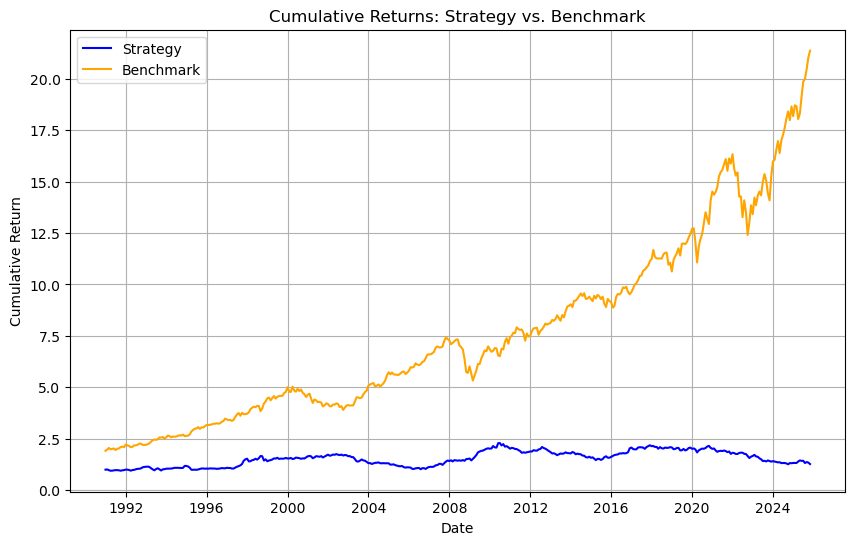

In [101]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()